In [1]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors


%matplotlib inline
plt.rcParams.update({'font.size': 20})

from sklearn.feature_extraction.image import grid_to_graph
from mpl_toolkits.axes_grid1 import ImageGrid
import json
from matplotlib.ticker import FuncFormatter

import nibabel as nib

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import itertools
import random
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm

from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression
import matplotlib.patches as patches

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

from scipy.fftpack import fft,fftshift,ifft

In [2]:
n_clusters = 2000
labels_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices/cluster_labels.npy'
cluster_model_labels = np.load(labels_file)

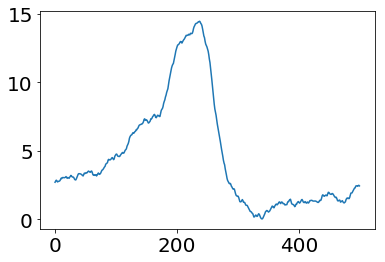

In [3]:
main_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201221_neural_weighted_behavior/"

response_files = [os.path.join(main_path, file) for file in os.listdir(main_path) if 'responses' in file]
bbb.sort_nicely(response_files)

responses = []
for file in response_files:
    responses.append(np.load(file))
responses = np.asarray(responses)
responses.shape

responses_split = np.reshape(responses, (49,2000,3,500))
responses_fft = fft(responses_split,axis=-1)
responses_fft[:,:,:,15:23] = 0
responses_fft[:,:,:,475:485] = 0
responses_filtered = ifft(responses_fft,axis=-1)
responses_filtered.shape

cluster_id = np.argmax(np.sum(responses_filtered[20,:,0,:].real, axis=1))
plt.plot(responses_filtered[20,cluster_id,0,:])

In [4]:
responses_filtered.shape

(49, 2000, 3, 500)

In [5]:
responses_filtered = np.reshape(responses_filtered,(49,2000,1500))

all_z = []
for z in range(49):
    colored_by_betas = np.zeros((256*128,1500))
    for cluster_num in range(n_clusters):
        cluster_indicies = np.where(cluster_model_labels[z,:]==cluster_num)[0]
        colored_by_betas[cluster_indicies,:] = responses_filtered[z,cluster_num,:]
    colored_by_betas = colored_by_betas.reshape(256,128,1500)
    all_z.append(colored_by_betas)
all_z = np.asarray(all_z)

all_z = np.swapaxes(all_z,1,2)
all_z.shape

(49, 128, 256, 1500)

In [28]:
peak_max = np.max(all_z[:,:,:,500:1000],axis=-1)
peak_time = np.argmax(all_z[:,:,:,500:1000],axis=-1)
peak_time[np.where(peak_max<6)] = 0

In [29]:
start = 265
end = 220
middle = 250

# sample the colormaps that you want to use. Use 128 from each so we get 256
# colors in total
colors1 = plt.cm.Blues_r(np.linspace(0., 1, middle-end))
colors2 = plt.cm.Reds(np.linspace(0, 1, start-middle))

# combine them and build a new colormap
colors = np.vstack((colors1, colors2))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

mymap.set_bad(color='black')

In [30]:
peak_time = np.ndarray.astype(peak_time,'float')
peak_time[np.where(peak_time==0)] = np.nan

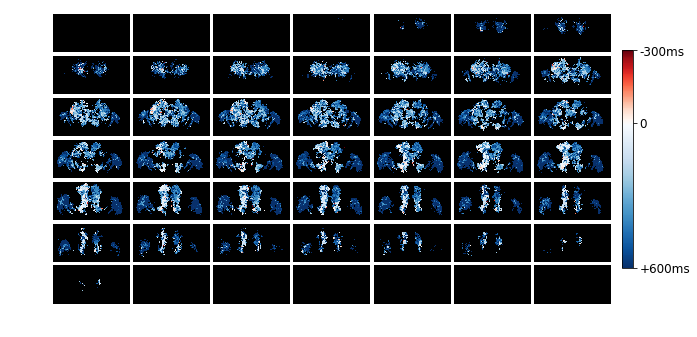

In [32]:
fig = plt.figure(figsize=(10,10))
grid = ImageGrid(fig, 111, nrows_ncols=(7, 7), axes_pad=.05)
for i in range(49):
    cax = grid[i].imshow(peak_time[i,:,:],cmap=mymap,vmin=end,vmax=start);
    grid[i].axis('off')

cbar = fig.colorbar(cax, ticks=[start, middle, end],shrink=.4, anchor=(1.3,.5))
cbar.ax.set_yticklabels(['-300ms', '0', '+600ms'], fontsize=12)
    
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight')#

[Text(1, 0, '-300ms'), Text(1, 0, '0'), Text(1, 0, '+600ms')]

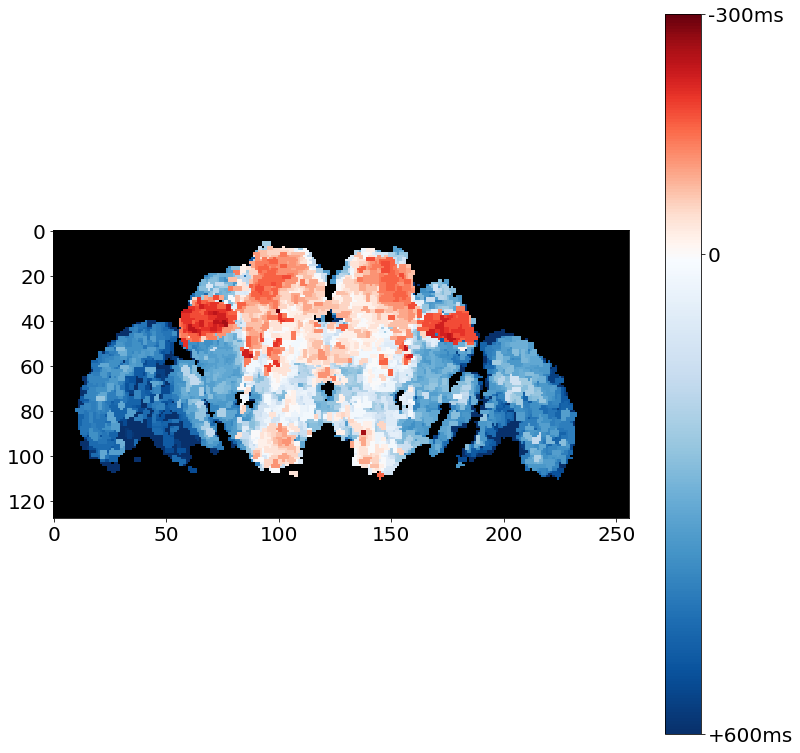

In [8]:
# max projection
out = np.max(peak_time,axis=0)
out = np.ndarray.astype(out,'float')
out[np.where(out==0)] = np.nan

fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([1,1,1,1])
cax = ax.imshow(out,cmap=mymap,vmin=end,vmax=start)

#plt.colorbar()
cbar = fig.colorbar(cax, ticks=[start, middle, end])
cbar.ax.set_yticklabels(['-300ms', '0', '+600ms'])

In [50]:
def get_map_at_timepoint(z,behavior,timepoint):
    colored_by_betas = np.zeros((256*128))
    for cluster_num in range(n_clusters):
        cluster_indicies = np.where(cluster_model_labels[z,:]==cluster_num)[0]
        value = responses_filtered[z,cluster_num,behavior,timepoint]
        if value > 8:
            mask = 1
        else:
            mask = 0
        if len(cluster_indicies) > 100:
            mask = np.nan
        colored_by_betas[cluster_indicies] = responses_filtered[z,cluster_num,behavior,timepoint] * mask
    colored_by_betas = colored_by_betas.reshape(256,128)
    return colored_by_betas

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


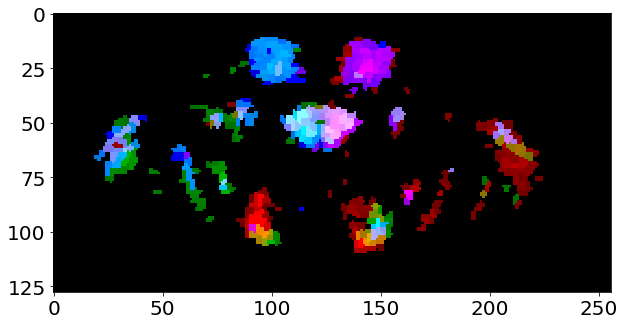

In [81]:
z=20
timepoint = 250
behaviors = [0,1,2]
maps = []
for behavior in behaviors:
    maps.append(get_map_at_timepoint(z,behavior,timepoint))

norm_min = 0
norm_max = np.max(np.nan_to_num(maps))

colors3 = Normalize(norm_min, norm_max/2)(maps[0])
colors2 = Normalize(norm_min, norm_max)(maps[1])
colors1 = Normalize(norm_min, norm_max)(maps[2])

to_plot = np.stack((colors1,colors2,colors3),axis=2)
to_plot = np.swapaxes(to_plot,0,1)

plt.figure(figsize=(10,10))
plt.imshow(to_plot*1.3)

In [ ]:
norm_min = 0
norm_max = np.max(np.nan_to_num(map_z_neg))
z=18
slices = []
for z in range(49):
    colors1 = Normalize(norm_min, norm_max)(map_z_neg_smo[z,:,:].T)
    colors2 = Normalize(norm_min, norm_max)(map_z_pos_smo[z,:,:].T)
    colors3 = Normalize(norm_min, norm_max)(map_y_pos_smo[z,:,:].T)

    empty = np.zeros(colors1.shape)
    to_plot = np.stack((colors1,colors2,colors3),axis=2)
    slices.append(to_plot)

In [82]:
20*250

5000

In [83]:
responses_filtered.shape

(49, 2000, 3, 500)

In [84]:
responses_filtered = np.reshape(responses_filtered,(49,2000,1500))

all_z = []
for z in range(49):
    colored_by_betas = np.zeros((256*128,1500))
    for cluster_num in range(n_clusters):
        cluster_indicies = np.where(cluster_model_labels[z,:]==cluster_num)[0]
        colored_by_betas[cluster_indicies,:] = responses_filtered[z,cluster_num,:]
    colored_by_betas = colored_by_betas.reshape(256,128,1500)
    all_z.append(colored_by_betas)
all_z = np.asarray(all_z)

all_z = np.swapaxes(all_z,1,2)
all_z.shape

(49, 128, 256, 1500)

In [243]:
peak_max = np.max(all_z[:,:,:,:500],axis=-1)
peak_time = np.argmax(all_z[:,:,:,:500],axis=-1)
peak_time[np.where(peak_max<6)] = 0

In [240]:
peak_max = np.max(all_z[:,:,:,500:1000],axis=-1)
peak_time = np.argmax(all_z[:,:,:,500:1000],axis=-1)
peak_time[np.where(peak_max<6)] = 0

In [244]:
start = 265
end = 220
middle = 250

# sample the colormaps that you want to use. Use 128 from each so we get 256
# colors in total
colors1 = plt.cm.Blues_r(np.linspace(0., 1, middle-end))
colors2 = plt.cm.Reds(np.linspace(0, 1, start-middle))

# combine them and build a new colormap
colors = np.vstack((colors1, colors2))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

mymap.set_bad(color='black')

In [246]:
15*20

300

[Text(1, 0, '-300ms'), Text(1, 0, '0'), Text(1, 0, '+600ms')]

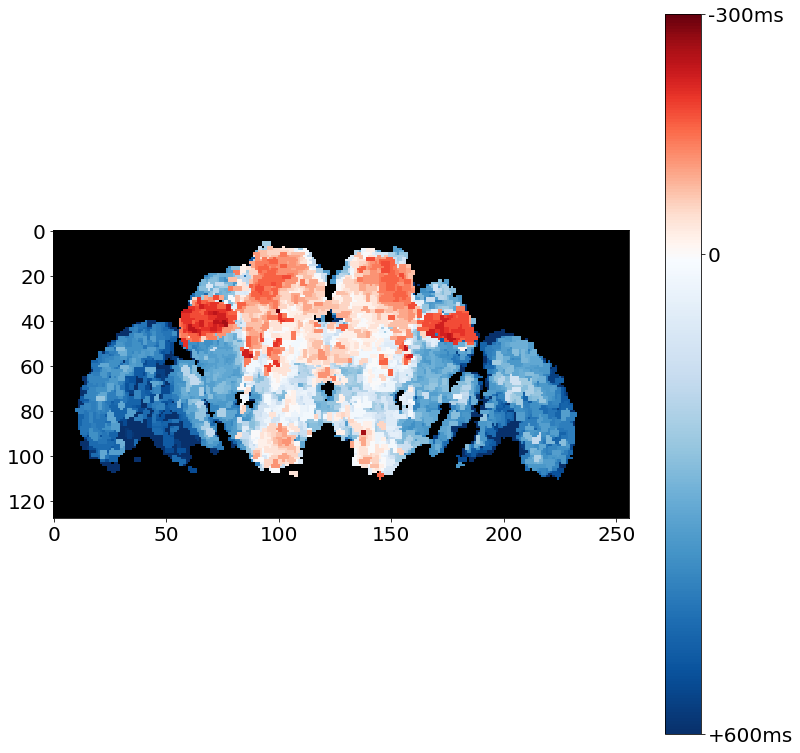

In [248]:
# max projection
out = np.max(peak_time,axis=0)
out = np.ndarray.astype(out,'float')
out[np.where(out==0)] = np.nan

fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([1,1,1,1])
cax = ax.imshow(out,cmap=mymap,vmin=end,vmax=start)

#plt.colorbar()
cbar = fig.colorbar(cax, ticks=[start, middle, end])
cbar.ax.set_yticklabels(['-300ms', '0', '+600ms'])

[Text(1, 0, '< -1'), Text(1, 0, '0'), Text(1, 0, '> 1')]

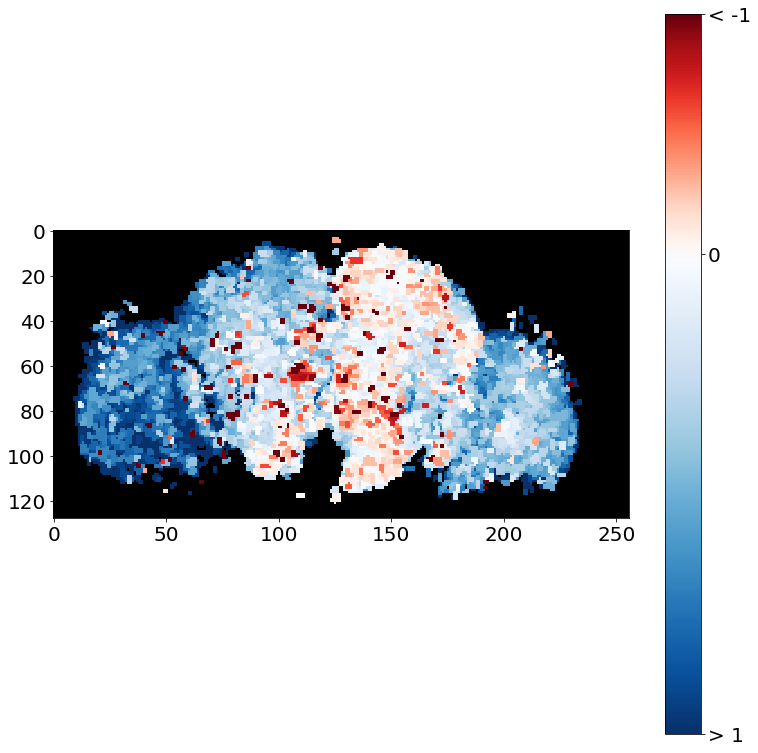

In [239]:
# max projection
out = np.max(peak_time,axis=0)
out = np.ndarray.astype(out,'float')
out[np.where(out==0)] = np.nan

fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([1,1,1,1])
cax = ax.imshow(out,cmap=mymap,vmin=end,vmax=start)

#plt.colorbar()
cbar = fig.colorbar(cax, ticks=[start, middle, end])
cbar.ax.set_yticklabels(['< -1', '0', '> 1'])

[Text(1, 0, '< -1'), Text(1, 0, '0'), Text(1, 0, '> 1')]

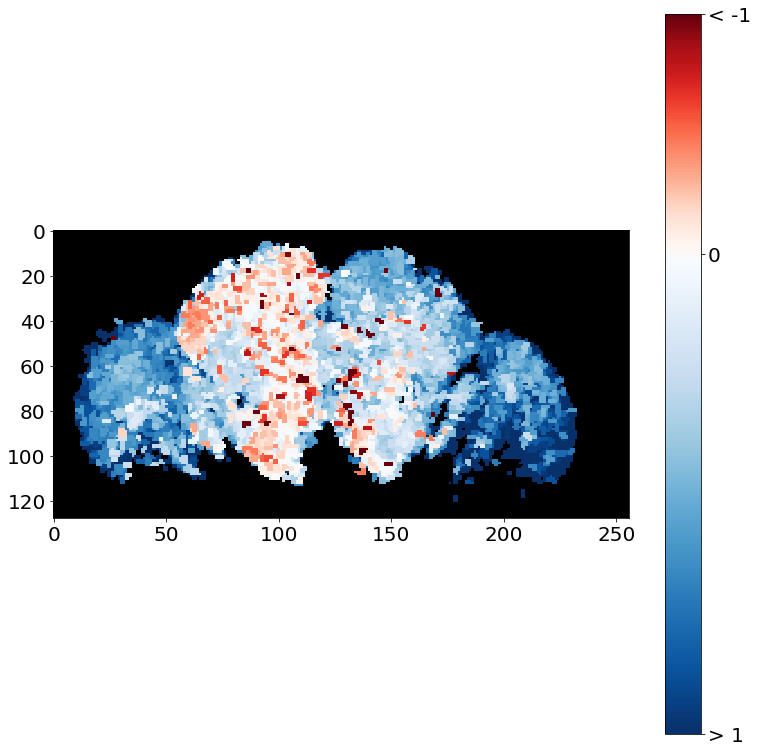

In [242]:
# max projection
out = np.max(peak_time,axis=0)
out = np.ndarray.astype(out,'float')
out[np.where(out==0)] = np.nan

fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([1,1,1,1])
cax = ax.imshow(out,cmap=mymap,vmin=end,vmax=start)

#plt.colorbar()
cbar = fig.colorbar(cax, ticks=[start, middle, end])
cbar.ax.set_yticklabels(['< -1', '0', '> 1'])

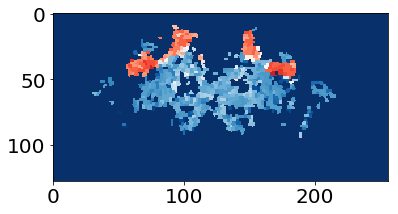

In [224]:
plt.imshow(peak_time[13,:,:],cmap=mymap,vmin=end,vmax=start)

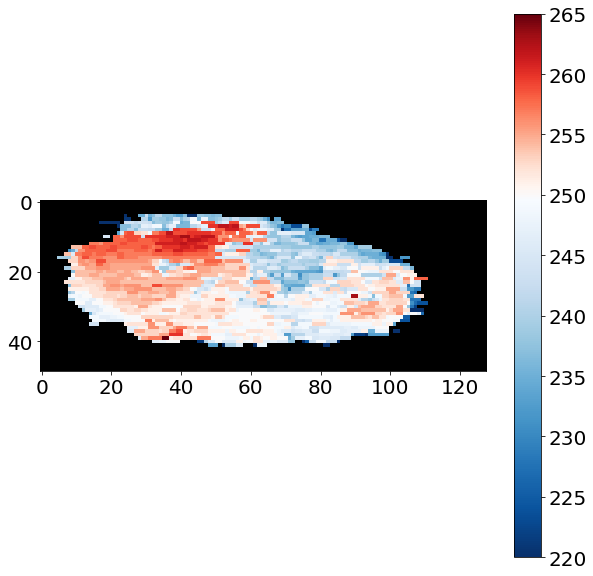

In [196]:
# max projection
out = np.max(peak_time,axis=2)
out = np.ndarray.astype(out,'float')
out[np.where(out==0)] = np.nan

plt.figure(figsize=(10,10))
plt.imshow(out,cmap=mymap,vmin=end,vmax=start)
plt.colorbar()

(0, 30000)

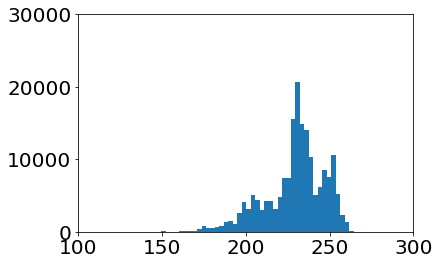

In [146]:
plt.hist(peak_time.ravel(),bins=100);
plt.xlim(100,300)
plt.ylim(0,30000)

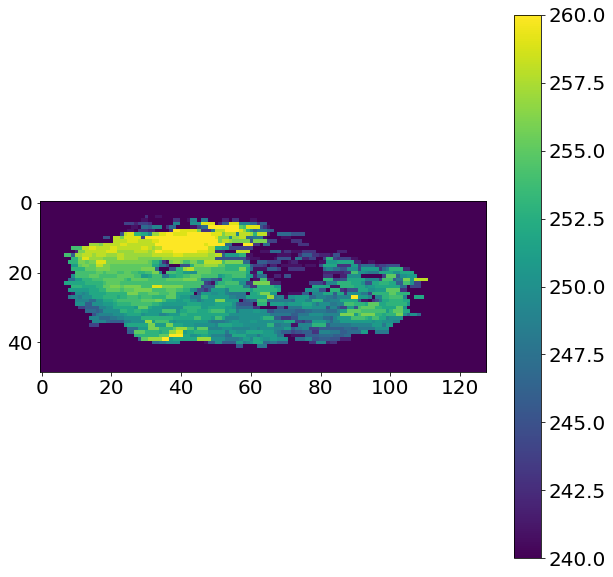

In [118]:
plt.figure(figsize=(10,10))
plt.imshow(out,vmin=240,vmax=260)
plt.colorbar()

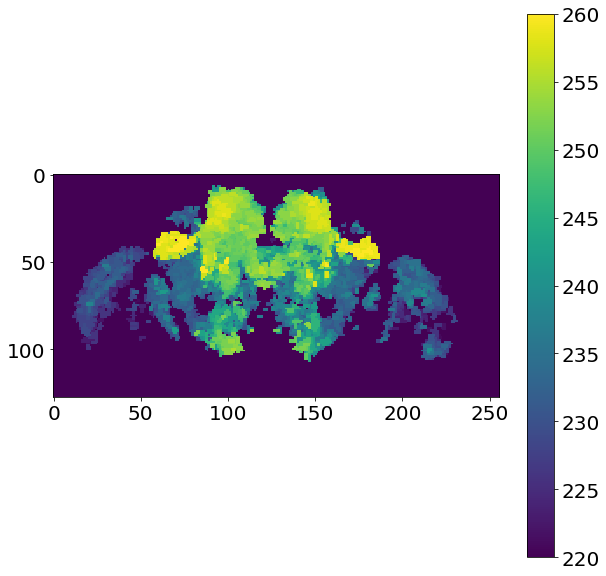

In [113]:
plt.figure(figsize=(10,10))
plt.imshow(out,vmin=220,vmax=260)
plt.colorbar()

In [85]:
out = np.max(all_z,axis=0)
out = np.swapaxes(out,0,1)
out = out[:,:,0:500]
out.shape

(256, 128, 500)

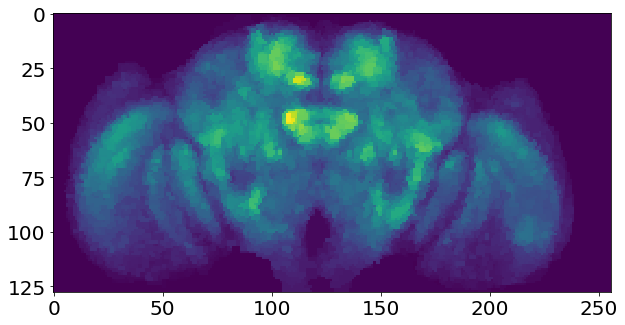

In [89]:
plt.figure(figsize=(10,10))
plt.imshow(out[:,:,240].T)

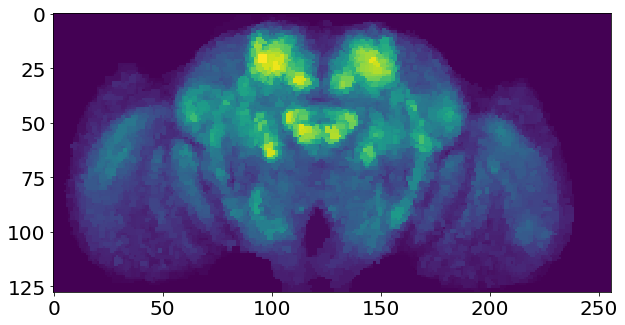

In [93]:
plt.figure(figsize=(10,10))
plt.imshow(out[:,:,260].T)

In [153]:
z=13
behavior = 0
time = 280
jump = 5

In [154]:
colored_by_betas = np.zeros((256*128))
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(cluster_model_labels[z,:]==cluster_num)[0]
    #colored_by_betas[cluster_indicies] = np.argmax(responses_filtered[z,cluster_num,0,:])
    response1 = responses_filtered[z,cluster_num,behavior,time+jump]
    response2 = responses_filtered[z,cluster_num,behavior,time-jump]
    colored_by_betas[cluster_indicies] = (response2-response1)
colored_by_betas = colored_by_betas.reshape(256,128)

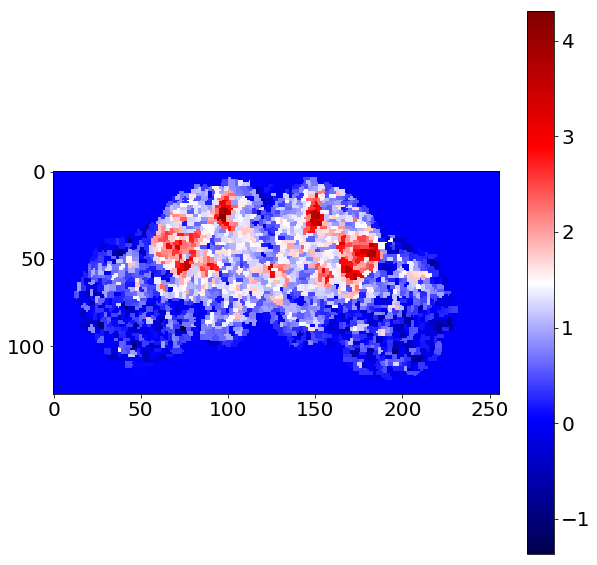

In [155]:
plt.figure(figsize=(10,10))
plt.imshow(colored_by_betas.T,cmap='seismic')
plt.colorbar()

In [160]:
colored_by_betas = np.zeros((256*128))
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(cluster_model_labels[z,:]==cluster_num)[0]
    #colored_by_betas[cluster_indicies] = np.argmax(responses_filtered[z,cluster_num,0,:])
    max_response = np.max(responses_filtered[z,cluster_num,behavior,:])
    if max_response > 6:
        mask = 1
    else:
        mask = 0
    if len(cluster_indicies) > 100:
        mask = np.nan
    colored_by_betas[cluster_indicies] = np.argmax(responses_filtered[z,cluster_num,behavior,:]) * mask
colored_by_betas = colored_by_betas.reshape(256,128)

In [197]:
colored_by_betas = np.zeros((256*128))
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(cluster_model_labels[z,:]==cluster_num)[0]
    #colored_by_betas[cluster_indicies] = np.argmax(responses_filtered[z,cluster_num,0,:])
    max_response = np.max(responses_filtered[z,cluster_num,behavior,:])
    if max_response > 6:
        mask = 1
    else:
        mask = 0
    if len(cluster_indicies) > 100:
        mask = np.nan
    colored_by_betas[cluster_indicies] = responses_filtered[z,cluster_num,behavior,280] * mask
colored_by_betas = colored_by_betas.reshape(256,128)

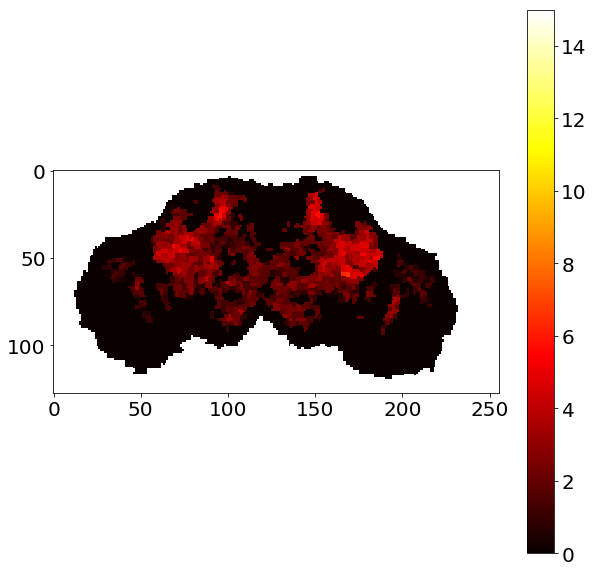

In [198]:
plt.figure(figsize=(10,10))
plt.imshow(colored_by_betas.T,vmin=0,vmax=15,cmap='hot')
plt.colorbar()

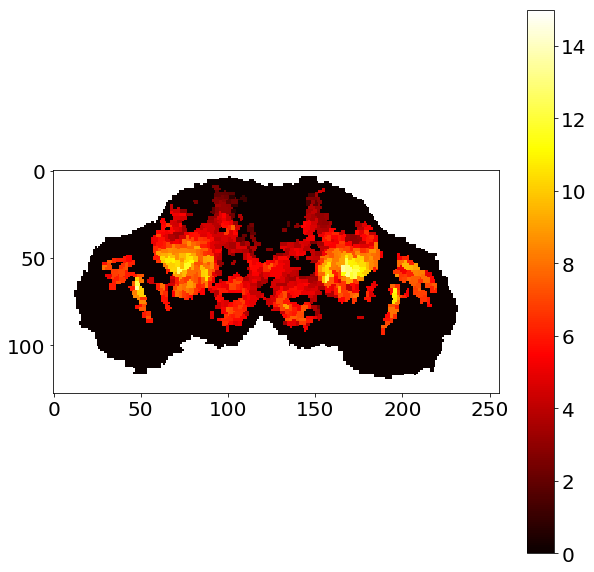

In [180]:
plt.figure(figsize=(10,10))
plt.imshow(colored_by_betas.T,vmin=0,vmax=15,cmap='hot')
plt.colorbar()

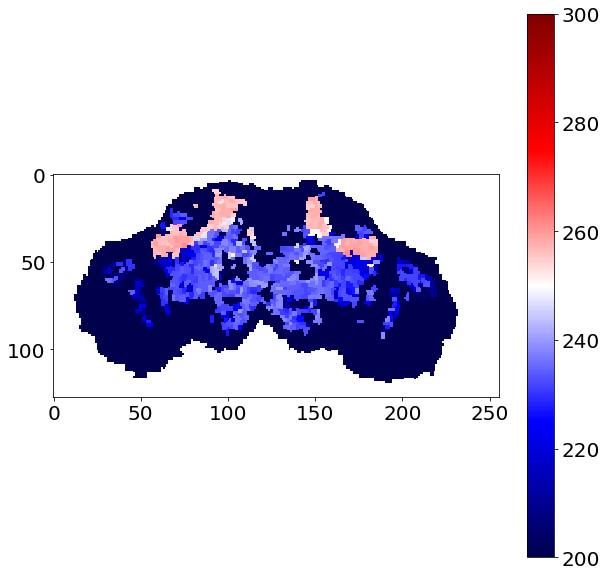

In [163]:
plt.figure(figsize=(10,10))
plt.imshow(colored_by_betas.T,vmin=200,vmax=300,cmap='seismic')
plt.colorbar()

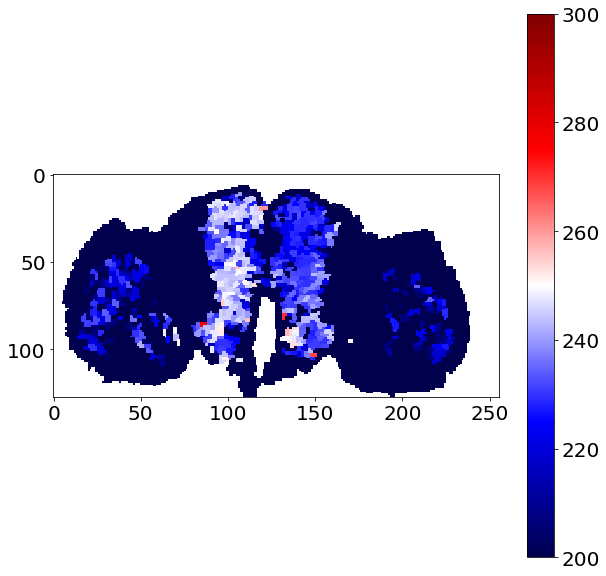

In [78]:
plt.figure(figsize=(10,10))
plt.imshow(colored_by_betas.T,vmin=200,vmax=300,cmap='seismic')
plt.colorbar()

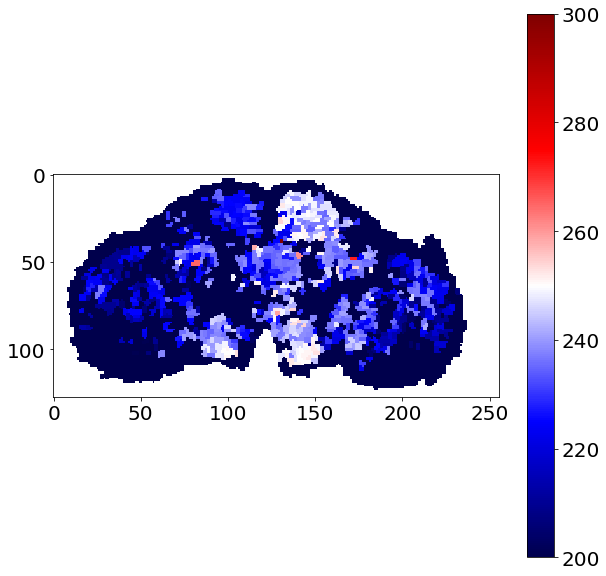

In [35]:
plt.figure(figsize=(10,10))
plt.imshow(colored_by_betas.T,vmin=200,vmax=300,cmap='seismic')
plt.colorbar()